In [1]:
#!pip install happybase

In [2]:
import numpy as np
import pandas as pd
import happybase as hb
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!pip install pyspark py4j

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('HBaseDataFrame').getOrCreate()

23/06/27 16:14:16 WARN Utils: Your hostname, Vicentes-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.110 instead (on interface en0)
23/06/27 16:14:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 16:14:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Reading CSV File

In [6]:
df = pd.read_csv('Fake_data.csv')
df.head()

,Unnamed: 0,Birth_Country,Email,First_Name,Income,Job,Last_name,Loan_Approved,SSN
0,0,Bosnia and Herzegovina,emily15@whitehead.com,Melissa,109957,Telecommunications researcher,Miranda,False,129-41-7773
1,1,Belgium,ronald87@yahoo.com,Curtis,301884,Animal nutritionist,Garrett,True,212-74-3976
2,2,United Kingdom,hannah29@gmail.com,Connor,341584,English as a foreign language teacher,Steele,False,024-35-3834
3,3,Kiribati,derrick59@hotmail.com,Adam,448293,"Surveyor, commercial/residential",Newman,False,157-82-4486
4,4,Malaysia,wendycarpenter@walker-knox.com,Jared,53621,Drilling engineer,Mann,True,199-56-2824


I personally consider that having the “Unamed” column is not necessary in this case, hence I decided to drop it from the DataFrame.

In [7]:
df = df.iloc[:, 1:]
df.head()

,Birth_Country,Email,First_Name,Income,Job,Last_name,Loan_Approved,SSN
0,Bosnia and Herzegovina,emily15@whitehead.com,Melissa,109957,Telecommunications researcher,Miranda,False,129-41-7773
1,Belgium,ronald87@yahoo.com,Curtis,301884,Animal nutritionist,Garrett,True,212-74-3976
2,United Kingdom,hannah29@gmail.com,Connor,341584,English as a foreign language teacher,Steele,False,024-35-3834
3,Kiribati,derrick59@hotmail.com,Adam,448293,"Surveyor, commercial/residential",Newman,False,157-82-4486
4,Malaysia,wendycarpenter@walker-knox.com,Jared,53621,Drilling engineer,Mann,True,199-56-2824


# HBase Mac Installation

Important steps:

- Mac has JAVA 1.17 as the default Java version. Because he HBase nature, I needed to change it to version 1.8 for it to work. This is done by downloading the java version in java website and then doing the following within the mac terminal:

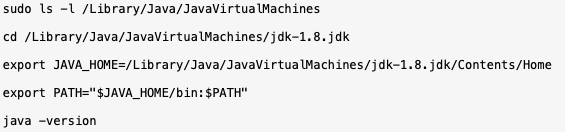

- Download Apache HBase 2.4.17 bin not src. (You do this by going to Apache HBase website)

- I store the HBase 2.4.17 file on my Desktop and proceeded to create two new files: hbase-data (hbase table storage) and zookepeer-data. Go to the "hbase-2.4.17" file and open the hbase-site.xml in order to change configurations to where I want to store my Hbase tables.

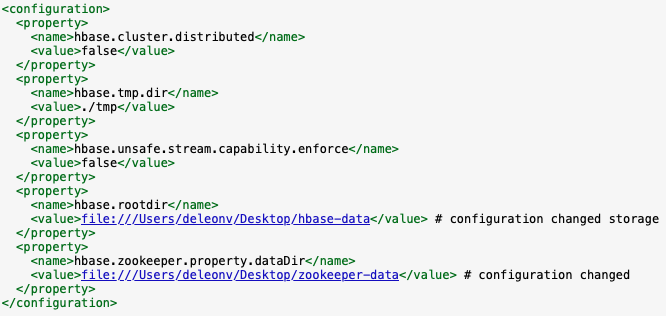

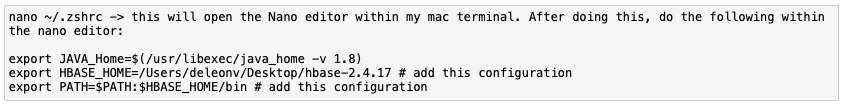

- Save (cntrl + o), press enter, exit nano editor (cntrl + x), and refresh the mac terminal (source ~/.zshrc)

- Running thrift server for connection:

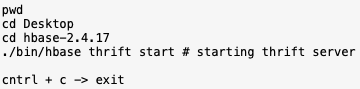

Resources:

- Java 1.8: https://www.youtube.com/watch?v=USKdqHp3Glg

- Java 1.8: https://stackoverflow.com/questions/22842743/how-to-set-java-home-environment-variable-on-mac-os-x-10-9

- Java 1.8: https://medium.com/notes-for-geeks/java-home-and-java-home-on-macos-f246cab643bd

- Apache Hbase: https://www.apache.org/dyn/closer.lua/hbase/2.4.17/hbase-2.4.17-bin.tar.gz

- HBase Installation: https://www.youtube.com/watch?v=KHrZpv0sjcw&t=515s

- HBase Installation/ Running: https://www.youtube.com/watch?v=dPJRQnHIpPA&t=193s

- HBase Installation: https://www.engati.com/blog/install-hbase-on-mac-in-5-minutes

- HBase Installation: https://ashwani-singh-nitk.medium.com/hbase-installation-on-mac-505b90dd1635

- HBase thrift: https://stackoverflow.com/questions/21878923/unable-to-start-hbase-thrift-server

- HBase thrift port (optional): https://docs.cloudera.com/HDPDocuments/HDP3/HDP-3.1.0/administration/content/hbase-ports.html

- HBase local instance and Python connection: https://towardsdatascience.com/setting-up-a-standalone-hbase-local-instance-and-connect-to-it-with-python-happybase-9751c9fe6941


# Storing the CSV File into HBase Table

It is important to state that I decided to switch to Jupyter Notebook because Google Colab wasn't compatible with HBase. Since it is a cloud-based platform, it doesn't have native support for HBase connection. Jupyter Notebook does supports this connection. Resource used in the storing process came from: 

- Happybase doc: https://happybase.readthedocs.io/en/latest/user.html

- Happybase doc: https://happybase.readthedocs.io/en/latest/

- Happybase doc: https://happybase.readthedocs.io/en/latest/api.html

- Bytes: https://docs.python.org/3/library/stdtypes.html#str.encode

- Connection: https://stackoverflow.com/questions/55292063/cannot-create-simple-table-using-happybase-in-python

- Designing Hbase tables: https://www.ibm.com/docs/en/db2-big-sql/5.0.4?topic=performance-hints-designing-hbase-tables

- Column families: https://stackoverflow.com/questions/64944559/why-do-we-need-column-families-in-hbase

- Column families: https://www.cockroachlabs.com/docs/stable/column-families.html

- Row iteration: https://sparkbyexamples.com/pandas/iterate-over-rows-in-pandas-dataframe/?expand_article=1

- Convert byteString key-value pair of dictionary to String: https://www.geeksforgeeks.org/python-convert-bytestring-keyvalue-pair-of-dictionary-to-string/

### Setting up the HBase connection

In [8]:
hostname = 'Vicentes-MacBook-Air.local' # my HBase host name
port = 9090 # default HBase port

connection = hb.Connection(hostname, port = port) # using happybase as hb

### Creating the Table

Tables (class Table) provide the main API to retrieve and manipulate data in HBase. Encode() will be used to convert strings to bytes. HBase does not have any notion of data types; all row keys, column names and column values are simply treated as raw byte strings (HBase uses bytes). Also, HBase tables are made of column families which are the logical and physical grouping of columns. The columns in one family are stored separately from the columns in another family. A column family is a group of columns in a table that are stored as a single key-value pair in the underlying key-value store. Column families reduce the number of keys stored in the key-value store, resulting in improved performance during operations.

We are going to iterate all rows using the df.iterrows() and apply str.encode() to get the strings encoded to bytes. Manually putting all the csv columns in the HBase table using the previous methods mentioned.

In [9]:
my_table = 'HBase_Table'

# worker (assign to empty dictionary) is the column family name for data iteration
column_families = {'worker': {}} # column family based on csv

connection.create_table(my_table, column_families) # creating the table

table = connection.table(my_table)

In [10]:
for index, row in df.iterrows(): # iterate all rows using df.iterrows()
    data = { # data dictionary
        b'worker:Birth_Country': str(row['Birth_Country']).encode(),
        b'worker:Email': str(row['Email']).encode(),
        b'worker:First_Name': str(row['First_Name']).encode(),
        b'worker:Income': str(row['Income']).encode(),
        b'worker:Job': str(row['Job']).encode(),
        b'worker:Last_name': str(row['Last_name']).encode(),
        b'worker:Loan_Approved': str(row['Loan_Approved']).encode(),
        b'worker:SSN': str(row['SSN']).encode()
    }

    table.put(str(index).encode(), data) # data into HBase
    
connection.close() # closing conneciton

# Spark SQL Reading HBase Table

Lets open a connection again and since PySpark "createDataFrame" seems to be expecting strings, I decided to convert data dictionary byteString key-value pairs to strings using 'utf-8' in order to print the DataFrame. After performing this operation, we implement the same sql operations from HomeWork 4 using the family column 'worker'.

In [12]:
hostname = 'Vicentes-MacBook-Air.local' # my HBase host name
port = 9090 # default HBase port

connection = hb.Connection(hostname, port = port) # using happybase as hb
table = connection.table('HBase_Table')

In [13]:
# converting data's byteString key-value pairs to strings using 'utf-8'
# I decided to do this after getting this error: 
# df = spark.createDataFrame(data), AssertionError: field name b'worker:Birth_Country' should be a string
# scanning over rows in the table

data = [{k.decode('utf-8'): v.decode('utf-8') for k, v in dict.items()} for key, dict in table.scan()]

In [14]:
sparkhb_df = spark.createDataFrame(data)
sparkhb_df.show(n=5, truncate=False)

+----------------------+--------------------------+-----------------+-------------+-----------------------------+----------------+--------------------+-----------+
|worker:Birth_Country  |worker:Email              |worker:First_Name|worker:Income|worker:Job                   |worker:Last_name|worker:Loan_Approved|worker:SSN |
+----------------------+--------------------------+-----------------+-------------+-----------------------------+----------------+--------------------+-----------+
|Bosnia and Herzegovina|emily15@whitehead.com     |Melissa          |109957       |Telecommunications researcher|Miranda         |False               |129-41-7773|
|Belgium               |ronald87@yahoo.com        |Curtis           |301884       |Animal nutritionist          |Garrett         |True                |212-74-3976|
|Armenia               |jennifer24@lynch-burch.com|Alexandra        |75778        |Water engineer               |Simon           |False               |217-96-3391|
|Slovenia       

In [15]:
sparkhb_df.printSchema() # You can see worker family column

root
 |-- worker:Birth_Country: string (nullable = true)
 |-- worker:Email: string (nullable = true)
 |-- worker:First_Name: string (nullable = true)
 |-- worker:Income: string (nullable = true)
 |-- worker:Job: string (nullable = true)
 |-- worker:Last_name: string (nullable = true)
 |-- worker:Loan_Approved: string (nullable = true)
 |-- worker:SSN: string (nullable = true)



In [16]:
df_temp = sparkhb_df.createOrReplaceTempView('Temporary_HBase_Table') # creating temporary table

In [17]:
# Checking if temporary table exists or not

table_exists = spark.catalog.tableExists('Temporary_HBase_Table')

if table_exists:
    print('Temporary_HBase_Table exists')
else:
    print('Temporary_HBase_Table does not exist')

Temporary_HBase_Table exists


# Question 1

In [47]:
query_1 = spark.sql('''
    SELECT `worker:Birth_Country`, COUNT(*) AS Total_Country
    FROM Temporary_HBase_Table
    GROUP BY `worker:Birth_Country`
    ORDER By Total_Country DESC
    LIMIT 1;
''')

query_1.show(truncate = False)

+--------------------+-------------+
|worker:Birth_Country|Total_Country|
+--------------------+-------------+
|Korea               |91           |
+--------------------+-------------+



In [48]:
query1_sql = query_1.first()[0]
print('Birth country which has highest amount of people is:', query1_sql)

Birth country which has highest amount of people is: Korea


# Question 2

In [36]:
query_2 = spark.sql('''
    SELECT `worker:Birth_Country`, AVG(`worker:Income`) AS Average_Income
    FROM Temporary_HBase_Table
    WHERE `worker:Birth_Country` = 'United States of America'
    GROUP BY `worker:Birth_Country`;
''')

query_2.show(truncate = False)

+------------------------+------------------+
|worker:Birth_Country    |Average_Income    |
+------------------------+------------------+
|United States of America|208759.82352941178|
+------------------------+------------------+



In [32]:
query2_sql = query_2.first()[1] # change from 0 to 1 because I want the avg income
print('The average income of people who are born in united states of america is:', query2_sql)

The average income of people who are born in united states of america is: 208759.82352941178


# Question 3

In [40]:
query_3 = spark.sql('''
    SELECT COUNT(*) AS Count_People_Income_Over_100K_No_Loan
    FROM Temporary_HBase_Table
    WHERE `worker:Income` > 100000 AND `worker:Loan_Approved` = 'False';
''')

query_3.show(truncate = False)

+-------------------------------------+
|Count_People_Income_Over_100K_No_Loan|
+-------------------------------------+
|4009                                 |
+-------------------------------------+



In [44]:
query3_sql = query_3.first()[0]
print('How many people has income over 100K but their loan is not approved? The amount of', query3_sql, 'people.')

How many people has income over 100K but their loan is not approved? The amount of 4009 people.


# Question 4

In [35]:
query_4 = spark.sql('''
    SELECT `worker:First_Name`, `worker:Last_Name`, `worker:Income`, `worker:Job`
    FROM Temporary_HBase_Table
    WHERE `worker:Birth_Country` = 'United States of America'
    ORDER BY `worker:Income` DESC
    LIMIT 10;
''')

query_4.show(truncate = False)

+-----------------+----------------+-------------+-------------------------------------------+
|worker:First_Name|worker:Last_Name|worker:Income|worker:Job                                 |
+-----------------+----------------+-------------+-------------------------------------------+
|Bobby            |Lopez           |7477         |Dietitian                                  |
|John             |Patterson       |74237        |Facilities manager                         |
|Arthur           |Thompson        |74114        |Electronics engineer                       |
|Christopher      |Gonzales        |71967        |Midwife                                    |
|Dorothy          |Hart            |68837        |Magazine features editor                   |
|Alejandro        |Hernandez       |66730        |Warden/ranger                              |
|Martha           |Vargas          |62632        |Illustrator                                |
|Alyssa           |Miller          |482588       |

# Question 5

In [37]:
query_5 = spark.sql('''
    SELECT COUNT(DISTINCT `worker:Job`) AS Count_Distinct_Jobs
    FROM Temporary_HBase_Table;
''')

query_5.show(truncate = False)

+-------------------+
|Count_Distinct_Jobs|
+-------------------+
|639                |
+-------------------+



In [39]:
query5_sql = query_5.first()[0]
print('How many number of distinct jobs are there?:', query5_sql, 'jobs.')

How many number of distinct jobs are there?: 639 jobs.


# Question 6

In [43]:
query_6 = spark.sql('''
    SELECT COUNT(*) AS Count_Writers_Icome_Less_Than_100K
    FROM Temporary_HBase_Table
    WHERE `worker:Job` = 'writer' AND `worker:Income` < 100000;
''')

query_6.show(truncate = False)

+----------------------------------+
|Count_Writers_Icome_Less_Than_100K|
+----------------------------------+
|0                                 |
+----------------------------------+



In [46]:
query6_sql = query_6.first()[0]
print('How many writers earn less than 100K?:', query6_sql, 'writers.')

How many writers earn less than 100K?: 0 writers.


#### Now, lets finish and close connection.

In [49]:
connection.close() # closing conneciton

# References:

PySpark SQL:

- Checking for temporary table: https://stackoverflow.com/questions/58067388/how-to-check-if-a-hive-table-exists-using-pyspark

- SQL AGG and Scalar functions: https://www.geeksforgeeks.org/sql-functions-aggregate-scalar-functions/

- SQL Queries in PySpark: https://medium.datadriveninvestor.com/pyspark-sql-and-dataframes-4c821615eafe

- SQL Tutorial/Functions: http://www-db.deis.unibo.it/courses/TW/DOCS/w3schools/sql/sql_alias.asp.html#gsc.tab=0

- Useful SQL SYNTAX: https://stackoverflow.com/questions/5391564/how-to-use-distinct-and-order-by-in-same-select-statement

- HomeWork4